In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser
from mpl_toolkits.mplot3d import Axes3D


# a

In [2]:
date_parser = lambda dates: parser.parse(dates, dayfirst=True)
# date_parser = lambda dates: pd.datetime.strptime(dates, "%d-%m-%Y")
data_time  = pd.read_csv("SP500_weekly_Jan1988_Nov2018.csv",parse_dates = ["Date"], 
                         index_col='Date', date_parser=date_parser)

In [3]:
def plot_close(datas):
    plt.figure(figsize= (30,10))
    for data in datas:
        plt.plot(data)
    plt.grid()
    

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


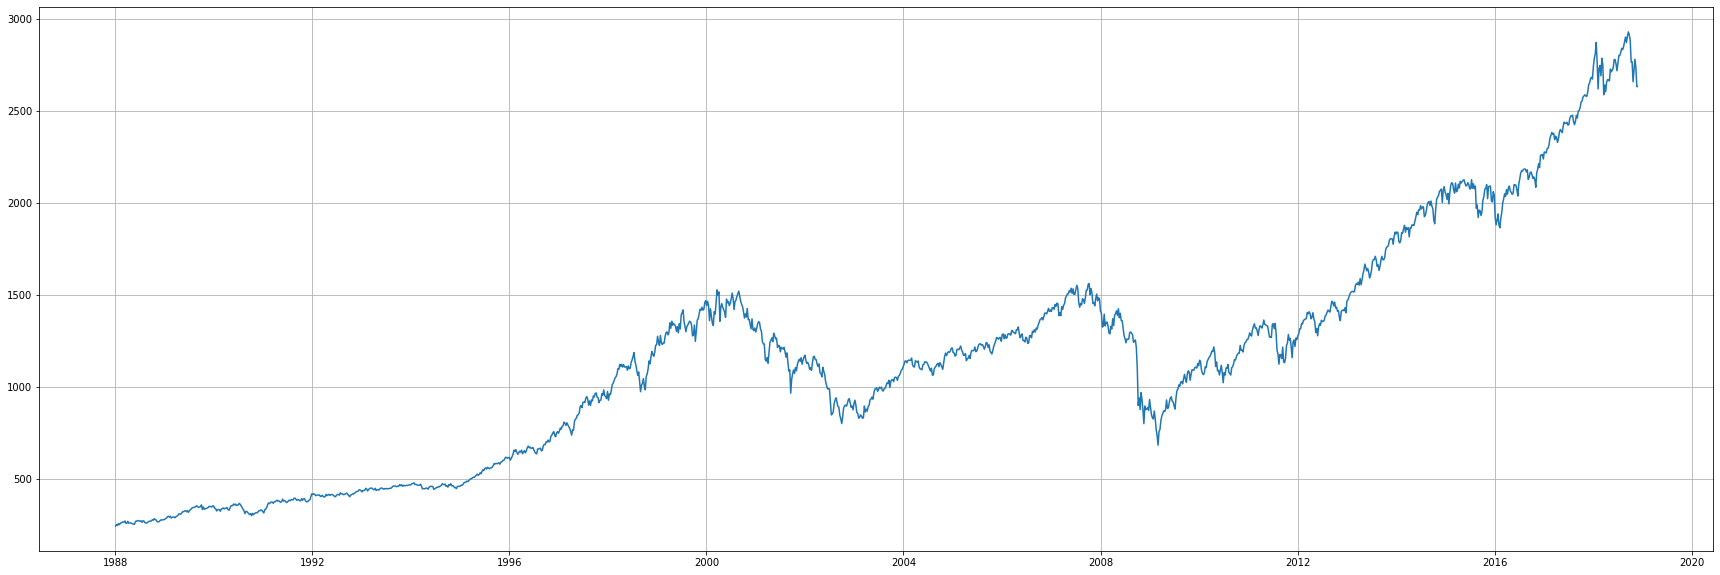

In [4]:
plot_close([data_time])

# b

In [5]:
data = pd.read_csv("SP500_weekly_Jan1988_Nov2018.csv")
data.index = data.index + 1
data = data["Adj Close"]


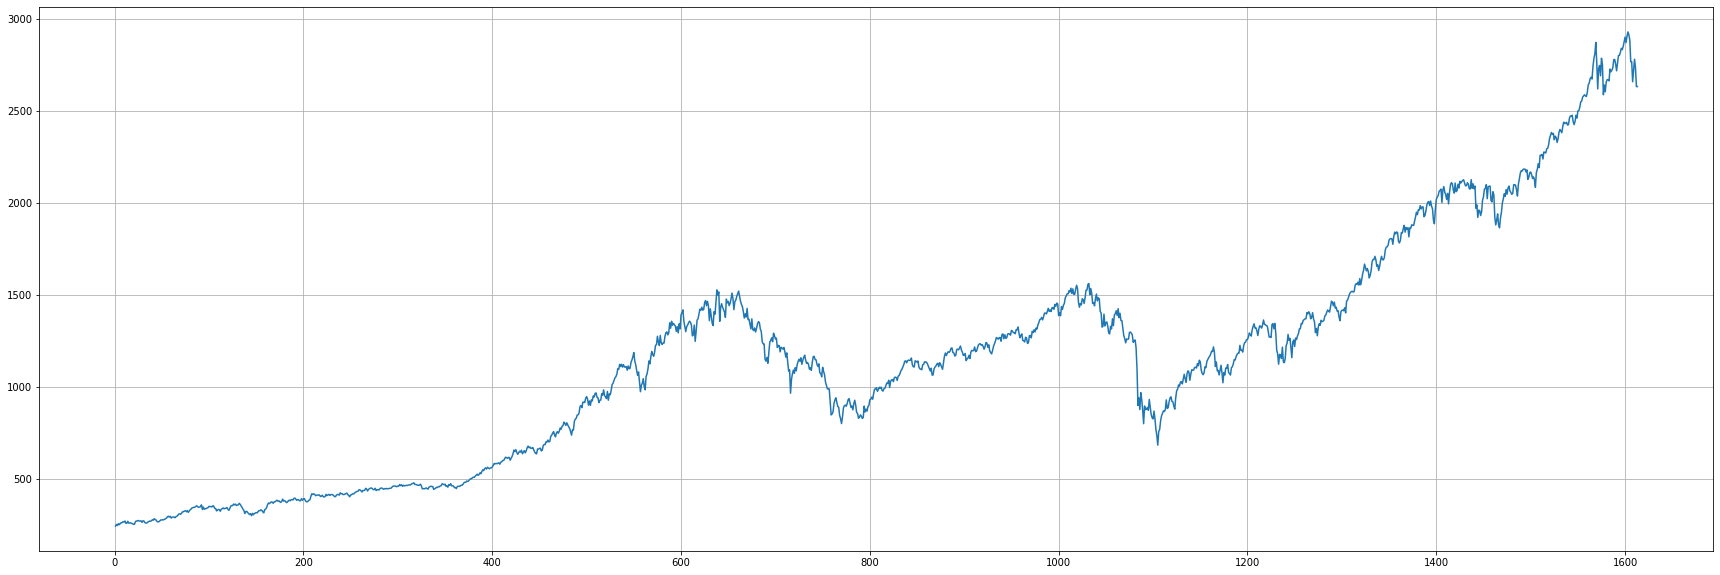

In [6]:
plot_close([data])

In [7]:
# def naive_drift(time_series,length):
#     """Naice forecast with drift
#     Allow the forecasts to increase or decrease over time, 
#     where the amount of change over time (called the drift) 
#     is set to be the average change seen in the historical data. 
    
#     Arg:
#         time_series: (pandas.Series)
#         length: (int)  
#     return:
#         s: (pandas.Series)
#     """
    
#     if length <= len(time_series):
#         y_init = time_series[1]
#         y_t = time_series[len(time_series) - length] # y1513

#         ts_changed = []

#         for i in range(length):
#             T = len(time_series) - length + i + 1
#             y_t = y_t + 1 * ((y_t - y_init) / (T - 1))
#             ts_changed.append(y_t)

#         s = pd.concat([time_series[:-length], pd.Series(ts_changed)])
#         s.index = range(1,len(s)+1)
#         return s
#     else:
#         print("")
        
        
        
def naive_drift(time_series):
    """Naice forecast with drift
    Allow the forecasts to increase or decrease over time, 
    where the amount of change over time (called the drift) 
    is set to be the average change seen in the historical data. 
    
    Arg:
        time_series: (pandas.Series)
        fore_len: (int)  
    return:
        s: (pandas.Series)
    """
    y_init = time_series[1]
    h = 1
    ts_changed = []

    for i in range(1, len(time_series)+1):
        T = i
        y_t = time_series[i]
        ts_changed.append(y_t + h * ((y_t - y_init) / (T - 1)))

    return pd.Series(ts_changed, index=np.arange(2,len(time_series)+2))

In [8]:
drift = naive_drift(data)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


In [9]:
data

1        243.399994
2        252.050003
3        246.500000
4        257.070007
5        250.960007
6        257.630005
7        261.609985
8        262.459991
9        267.299988
10       264.940002
11       271.119995
12       258.510010
13       258.890015
14       269.429993
15       259.769989
16       260.140015
17       261.329987
18       257.480011
19       256.779999
20       253.020004
21       253.419998
22       266.450012
23       271.260010
24       270.679993
25       273.779999
26       271.779999
27       270.019989
28       272.049988
29       263.500000
30       272.019989
           ...     
1584    2727.719971
1585    2712.969971
1586    2721.330078
1587    2734.620117
1588    2779.030029
1589    2779.659912
1590    2754.879883
1591    2718.370117
1592    2759.820068
1593    2801.310059
1594    2801.830078
1595    2818.820068
1596    2840.350098
1597    2833.280029
1598    2850.129883
1599    2874.689941
1600    2901.520020
1601    2871.679932
1602    2904.979980


In [10]:
drift

2               NaN
3        260.700012
4        248.050003
5        261.626678
6        252.850010
7        260.476007
8        264.644983
9        265.182848
10       270.287487
11       267.333336
12       273.891995
13       259.883648
14       260.180850
15       271.432301
16       260.939274
17       261.256016
18       262.450612
19       258.308247
20       257.523333
21       253.526320
22       253.920998
23       267.547632
24       272.526374
25       271.866080
26       275.045833
27       272.915199
28       271.043835
29       273.111099
30       264.217857
31       273.006885
           ...     
1585    2729.289346
1586    2714.529043
1587    2722.893441
1588    2736.190874
1589    2780.627779
1590    2781.257053
1591    2756.460424
1592    2719.926702
1593    2761.401727
1594    2802.916786
1595    2803.436123
1596    2820.435764
1597    2841.978280
1598    2834.902761
1599    2851.762150
1600    2876.336555
1601    2903.182384
1602    2873.322607
1603    2906.642428


In [11]:
data - drift

1              NaN
2              NaN
3       -14.200012
4         9.020004
5       -10.666671
6         4.779995
7         1.133978
8        -2.184992
9         2.117140
10       -5.347485
11        3.786659
12      -15.381985
13       -0.993633
14        9.249143
15      -11.662312
16       -0.799259
17        0.073971
18       -4.970601
19       -1.528248
20       -4.503329
21       -0.106322
22       12.529014
23        3.712378
24       -1.846381
25        1.913919
26       -3.265834
27       -2.895210
28        1.006153
29       -9.611099
30        7.802132
           ...    
1585    -16.319375
1586      6.801035
1587     11.726676
1588     42.839155
1589     -0.967867
1590    -26.377170
1591    -38.090307
1592     39.893366
1593     39.908332
1594     -1.086708
1595     15.383945
1596     19.914334
1597     -8.698251
1598     15.227122
1599     22.927791
1600     25.183465
1601    -31.502452
1602     31.657373
1603     23.027494
1604    -17.366765
1605    -30.075901
1606   -120.

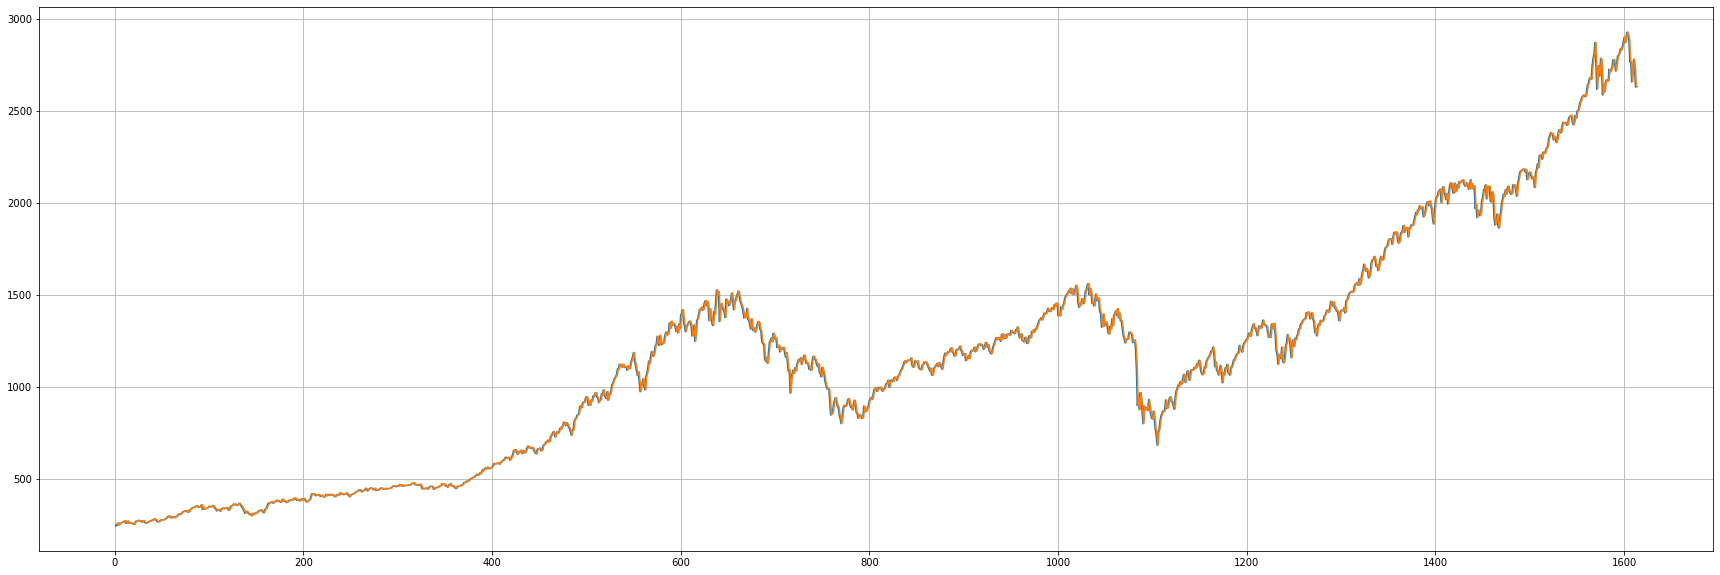

In [12]:
plot_close([data, drift])

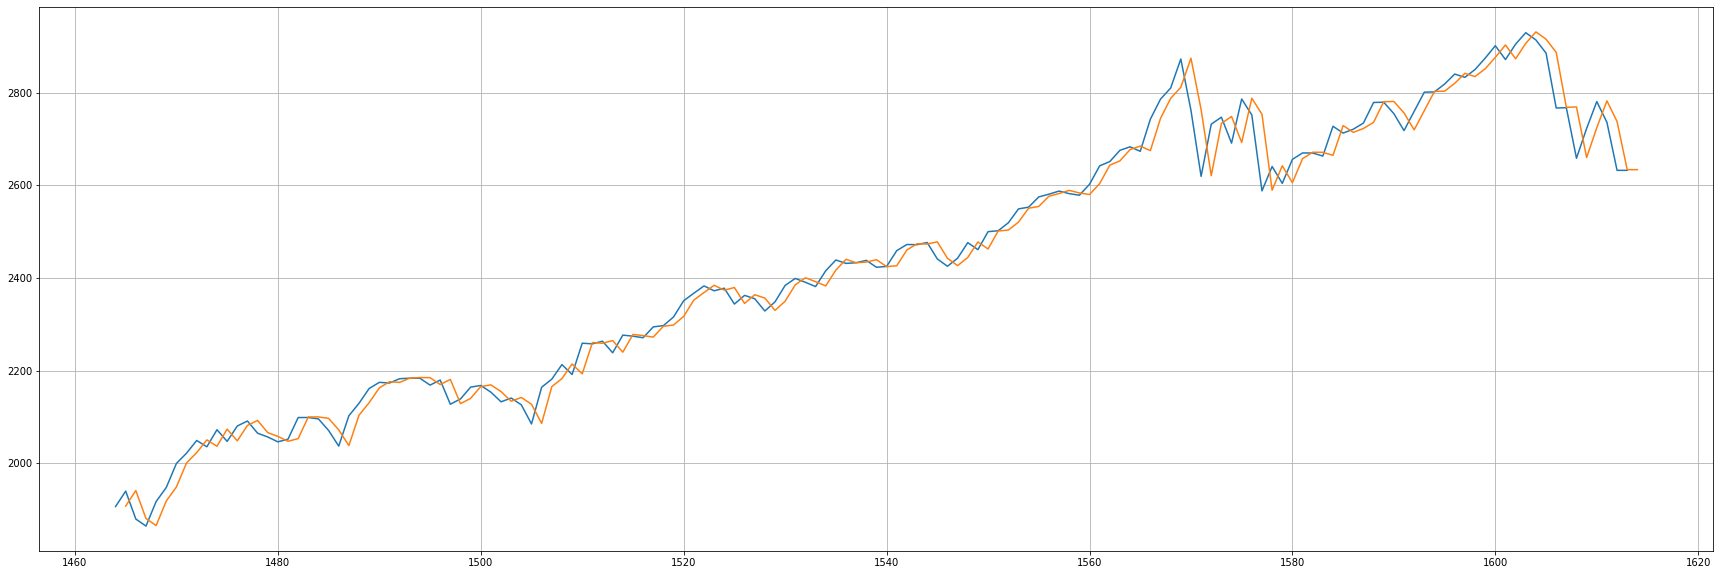

In [13]:
plot_close([data[-150:], drift[-150:]])

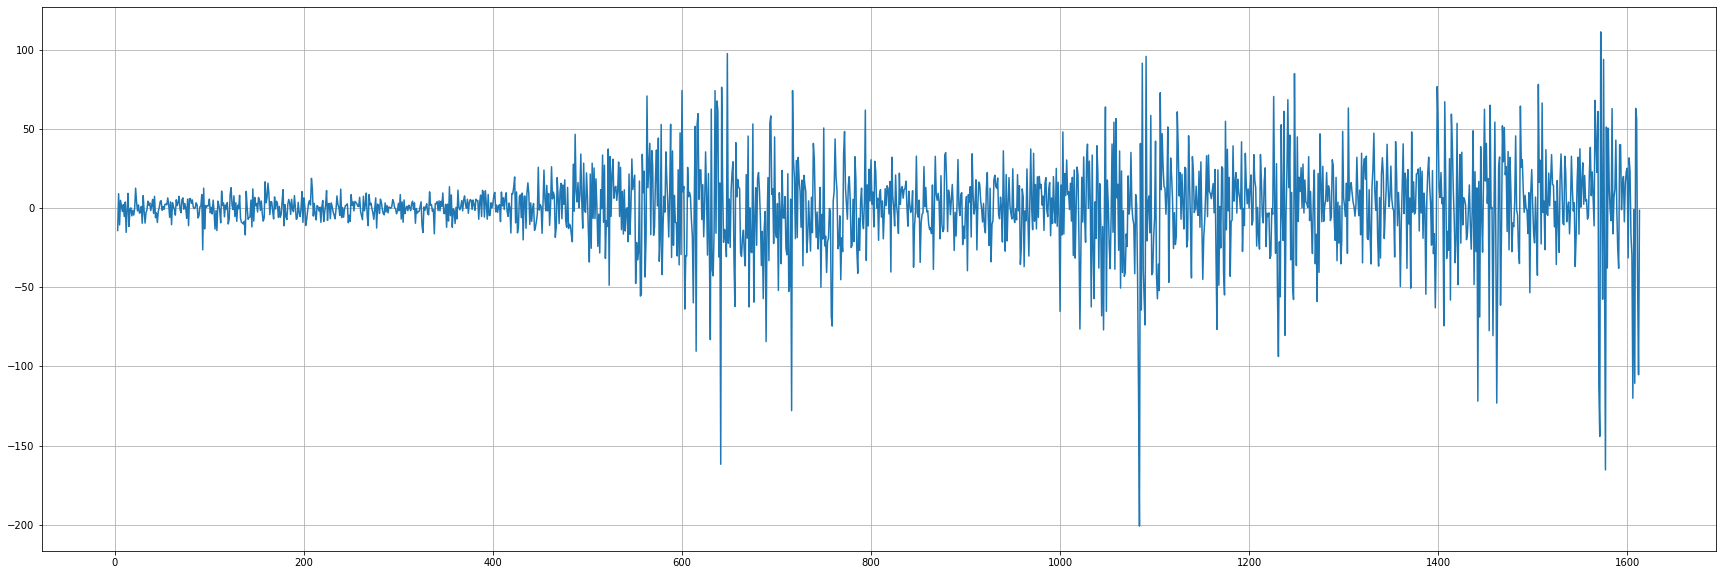

In [14]:
plot_close([(data - drift)])

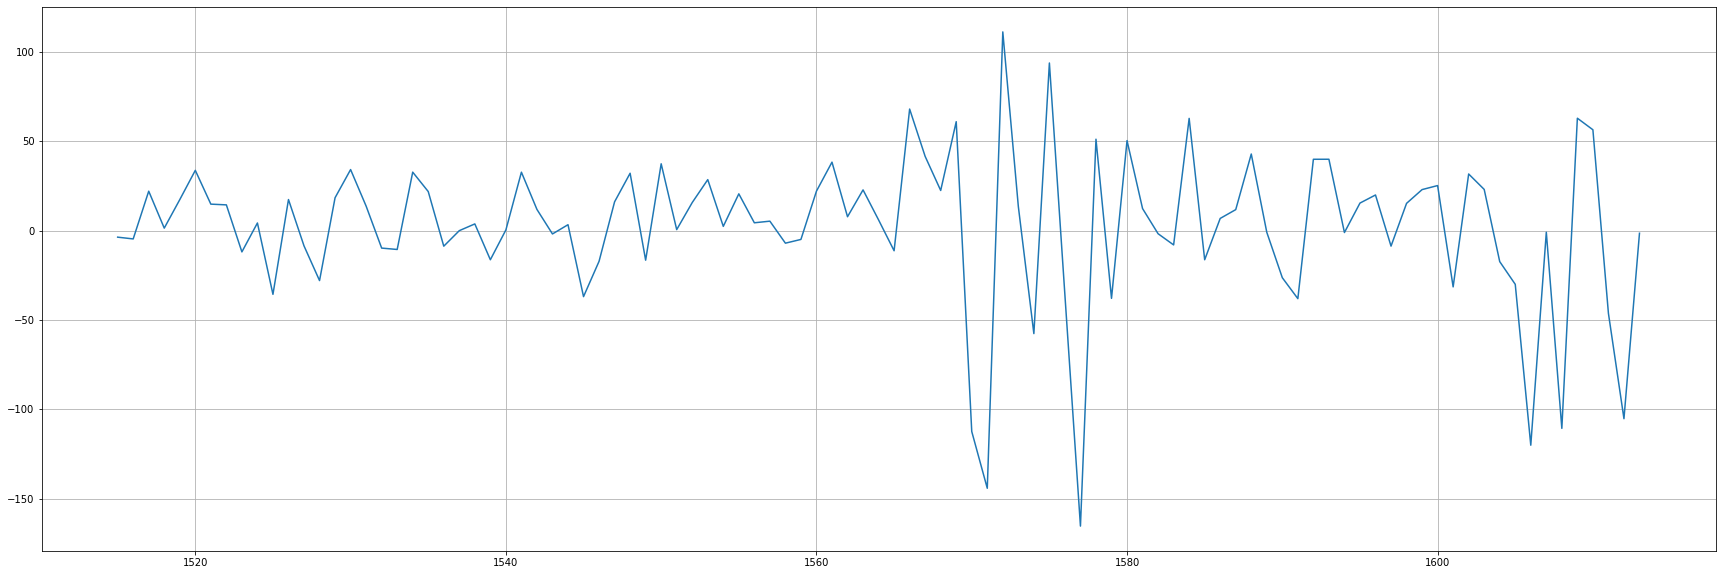

In [15]:
plot_close([(data - drift)[-100:]])


In [16]:
def rmse(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    diff = [(y_true[i] - y_pred[i]) for i in range(len(y_true))]
    diff =  np.array(diff)[~np.isnan(diff)]
    mse = 0
    for i in range(len(diff)):
        mse += diff[i] ** 2
    return np.sqrt(mse/len(diff))


# def rmse(YT, Y_hat):
#     YT,Y_hat= np.array(YT),np.array(Y_hat)
#     return np.sqrt(np.mean((YT - Y_hat)**2))



def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
data[-100:]

1514    2276.979980
1515    2274.639893
1516    2271.310059
1517    2294.689941
1518    2297.419922
1519    2316.100098
1520    2351.159912
1521    2367.340088
1522    2383.120117
1523    2372.600098
1524    2378.250000
1525    2343.979980
1526    2362.719971
1527    2355.540039
1528    2328.949951
1529    2348.689941
1530    2384.199951
1531    2399.290039
1532    2390.899902
1533    2381.729980
1534    2415.820068
1535    2439.070068
1536    2431.770020
1537    2433.149902
1538    2438.300049
1539    2423.409912
1540    2425.179932
1541    2459.270020
1542    2472.540039
1543    2472.100098
           ...     
1584    2727.719971
1585    2712.969971
1586    2721.330078
1587    2734.620117
1588    2779.030029
1589    2779.659912
1590    2754.879883
1591    2718.370117
1592    2759.820068
1593    2801.310059
1594    2801.830078
1595    2818.820068
1596    2840.350098
1597    2833.280029
1598    2850.129883
1599    2874.689941
1600    2901.520020
1601    2871.679932
1602    2904.979980


In [18]:
drift[1512:1612]

1514    2240.149807
1515    2278.324051
1516    2275.981531
1517    2272.648613
1518    2296.043035
1519    2298.773923
1520    2317.465513
1521    2352.547509
1522    2368.737417
1523    2384.526902
1524    2373.999047
1525    2379.651740
1526    2345.358313
1527    2364.109689
1528    2356.924141
1529    2330.315734
1530    2350.067749
1531    2385.600082
1532    2400.699117
1533    2392.302580
1534    2383.125757
1535    2417.237172
1536    2440.501404
1537    2433.195668
1538    2434.575520
1539    2439.728091
1540    2424.827344
1541    2426.597593
1542    2460.708897
1543    2473.986593
           ...     
1584    2664.949644
1585    2729.289346
1586    2714.529043
1587    2722.893441
1588    2736.190874
1589    2780.627779
1590    2781.257053
1591    2756.460424
1592    2719.926702
1593    2761.401727
1594    2802.916786
1595    2803.436123
1596    2820.435764
1597    2841.978280
1598    2834.902761
1599    2851.762150
1600    2876.336555
1601    2903.182384
1602    2873.322607


In [19]:
mean_absolute_percentage_error(data[-100:], drift[1512:1612])

1.1169590877371933

In [20]:
rmse(data[-100:], drift[1512:1612])

43.449216798690095

# c

In [21]:
def cma_n(ts,n):
    """
    """
    
    result = []
    if n % 2 == 0:
        for index in np.arange( n , len(ts)-n ):
#        print(index)
            sums = 0.5*(ts[index - n] + ts[index + n]) + ts[index - (n-1):index+n].sum() 
            mean = sums / 2 / n
            result.append(mean)
        
    nan = [np.nan]*n
    result = nan+result+nan
    return result

In [22]:
data.index = range(0, len(data))

#smoothed = pd.Series(cma_n(data,4), index = range(1, len(data)+1))
smoothed = pd.Series(data.rolling(2).mean().rolling(4).mean(), index = range(1, len(data)+1))

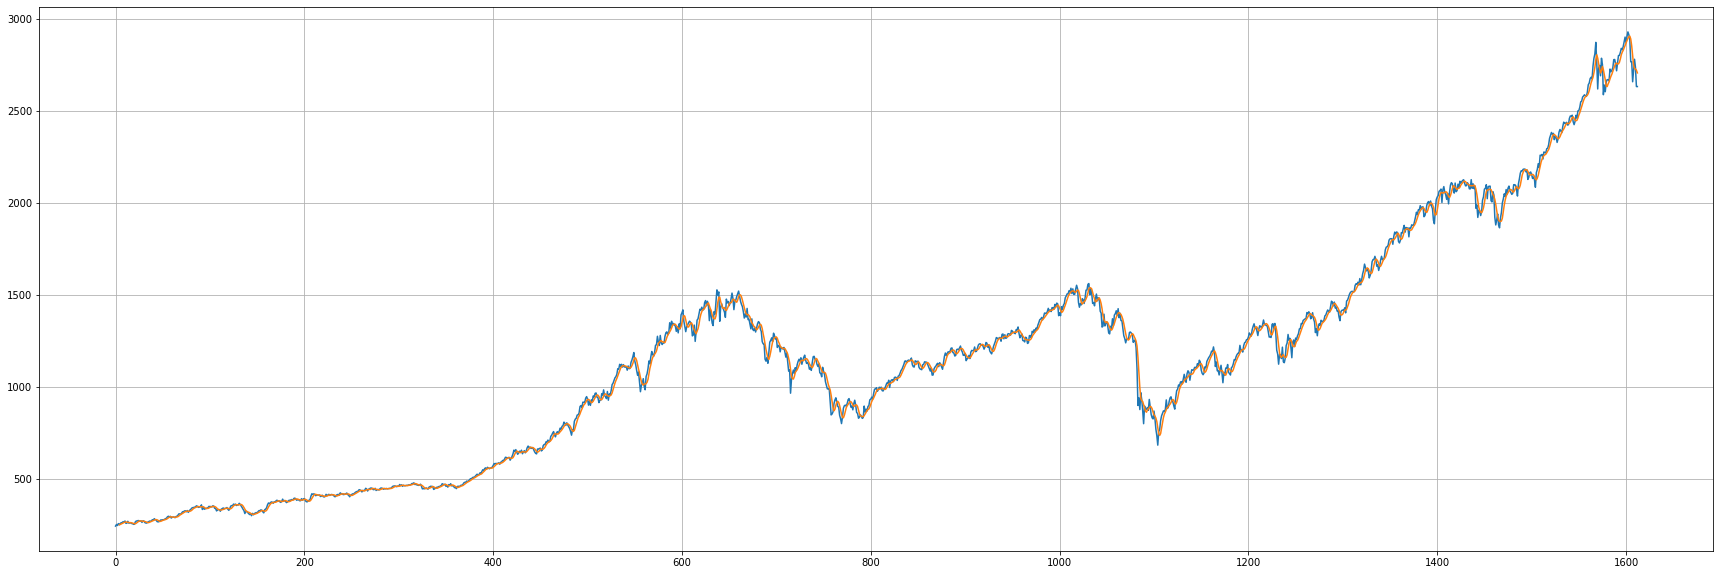

In [23]:
plot_close([data, smoothed])

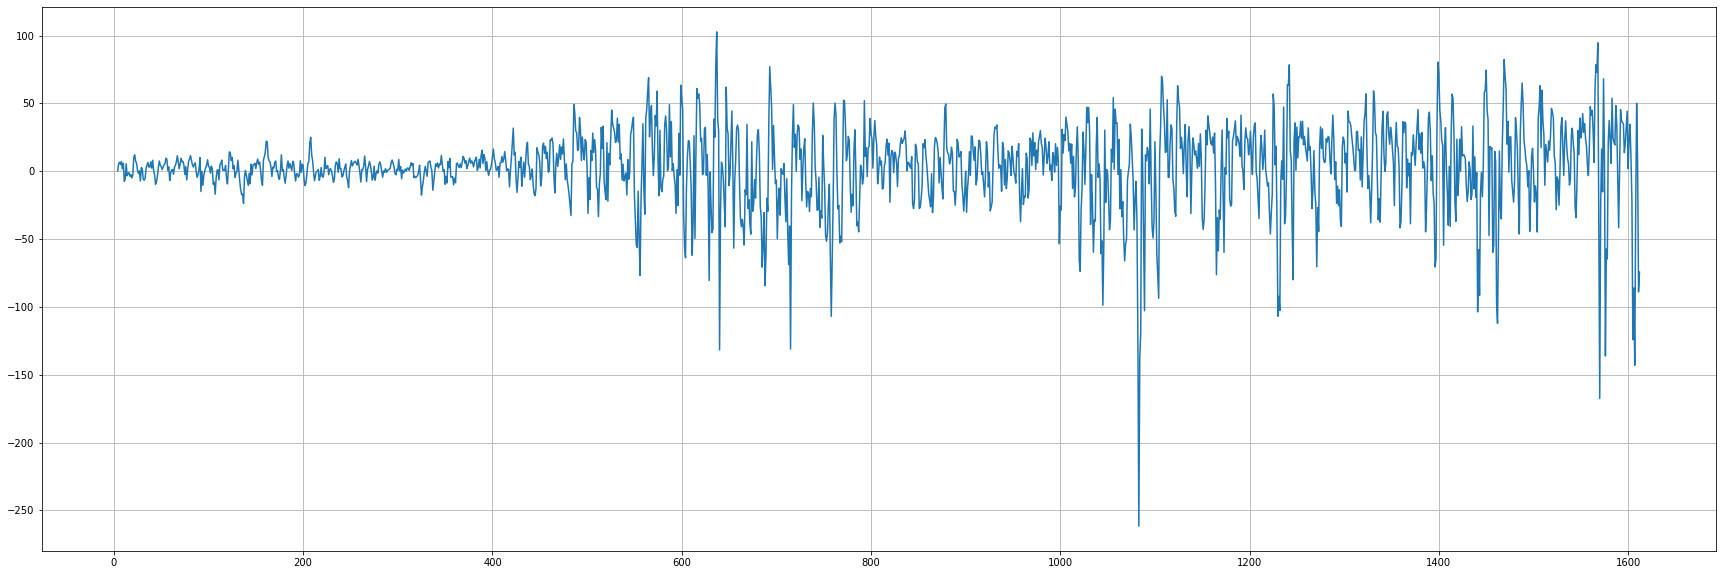

In [24]:
plot_close([data - smoothed])

# d

In [25]:
# def returns(ts):
#     """
#     """
#     r = []
#     for i in range(len(ts)-1):
#         temp = np.log(ts[i+1] / ts[i]) 
#         r.append(temp)
#     return pd.Series(r,index = range(1, len(r)+1))

return_data = pd.Series([np.log(data[i+1] / data[i]) for i in range(len(data)-1)], index = range(1, len(data)))

In [26]:
# data.index = range(0, len(data))
# return_data = returns(data)

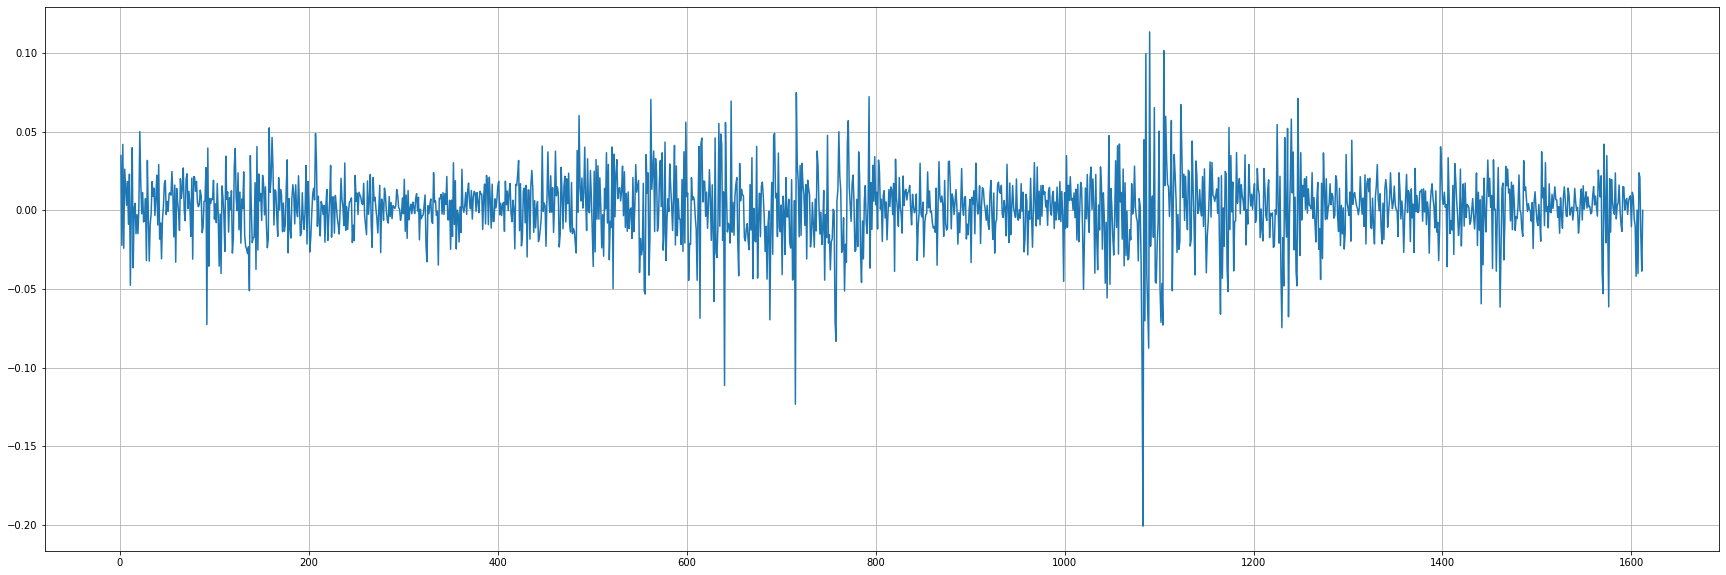

In [27]:
plot_close([return_data])

# e

In [28]:
def sse(x, y):
    return np.sum(np.power(x - y,2))

def sse_plot(sse):
    """
    """
    plt.figure()
    plt.plot(sse)
    plt.title("SSE for one step smoothing")
    plt.ylabel("SSE")
    plt.xlabel("Alpha")
    plt.xticks(np.linspace(0, 100, 11), ["{0:1.1f}".format(x) for x in np.linspace(0,1,11)])

def alpha_grid_search(train):
    sse_one = []
    alphas = np.arange(0.01,1,0.01)
    for i in alphas:
        smoothed = train.ewm(alpha = i, adjust=False).mean()
        sse_one.append(sse(smoothed[:-1], train.values[1:]))
        
    sse_plot(sse_one)
    
    optimal_alpha_one = alphas[np.argmin(sse_one)]
    print("Optimal Alpha for 1-step forecast is {0}".format(optimal_alpha_one))
    
    return optimal_alpha_one

# def ses_forecast(train, a, test):
#     """
#     """
#     smoothed = train.ewm(alpha=a, adjust=False).mean()

#     l_last = smoothed[len(smoothed)-1]
#     y_t = train[len(train)-1]
    
#     return pd.Series([a * y_t + (1 - a) * l_last] * len(test), index=test.index)
    
def ses_forecast(data, a, length):
    smoothed = data.ewm(alpha=a, adjust=False).mean().shift(1)
    print(smoothed)
    return smoothed[-length:]

Optimal Alpha for 1-step forecast is 0.91
0               NaN
1        243.399994
2        251.271502
3        246.929435
4        256.157356
5        251.427768
6        257.071804
7        261.201549
8        262.346731
9        266.854195
10       265.112279
11       270.579301
12       259.596246
13       258.953576
14       268.487115
15       260.554530
16       260.177321
17       261.226247
18       257.817172
19       256.873345
20       253.366805
21       253.415211
22       265.276880
23       270.721528
24       270.683731
25       273.501335
26       271.934919
27       270.192333
28       271.882799
29       264.254452
           ...     
1583    2663.992589
1584    2721.984507
1585    2713.781279
1586    2720.650686
1587    2733.362868
1588    2774.919985
1589    2779.233319
1590    2757.071692
1591    2721.853259
1592    2756.403055
1593    2797.268429
1594    2801.419530
1595    2817.254020
1596    2838.271451
1597    2833.729257
1598    2848.653827
1599    2872.34669

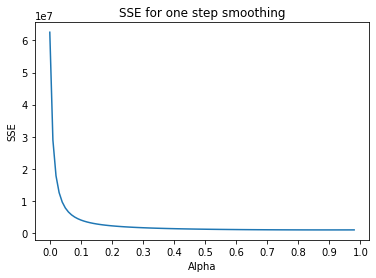

In [29]:
train = data[:-100]
test = data[-100:]

alpha = alpha_grid_search(train)

forecast = ses_forecast(data, alpha, length=len(test))

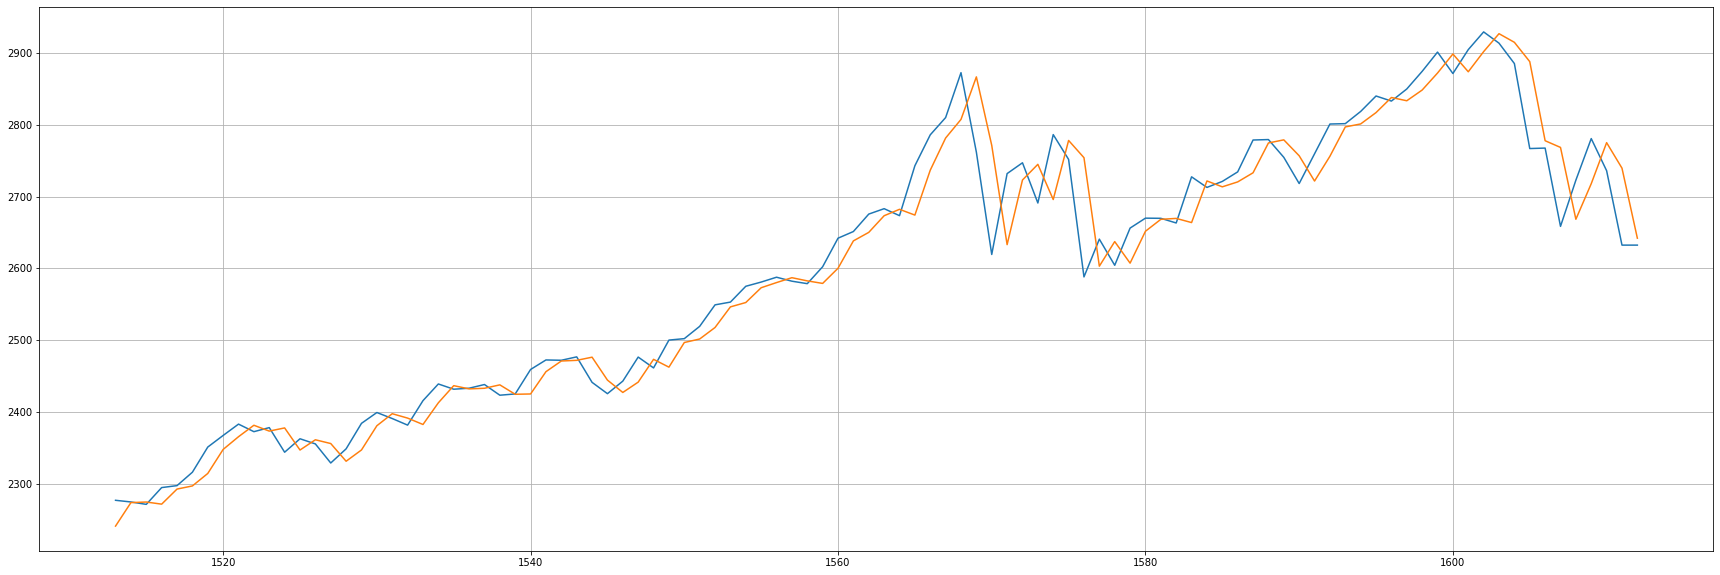

In [31]:
plot_close([test,forecast])

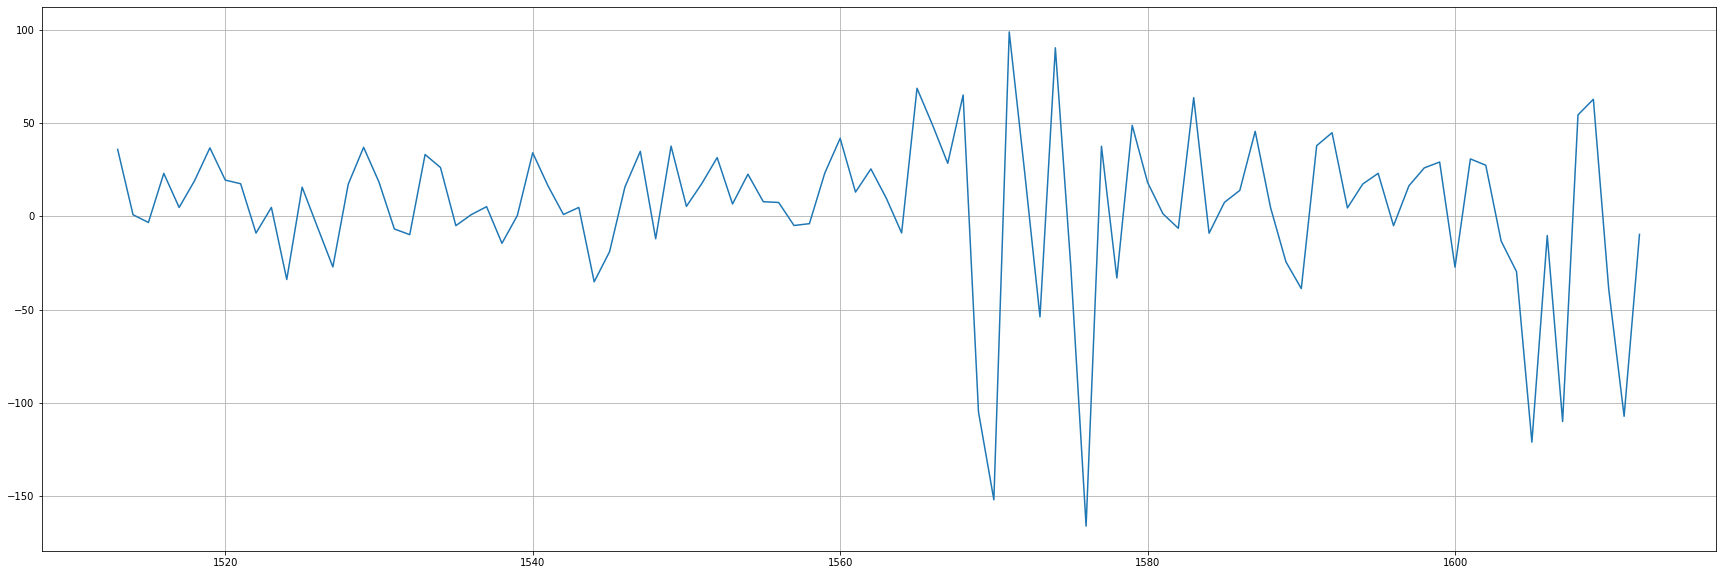

In [32]:
plot_close([test - forecast])

In [33]:
mean_absolute_percentage_error(test, forecast)

1.137363839580011

# f

In [34]:
return_square = return_data ** 2
train = return_square[:-100]
test = return_square[-100:]

Optimal Alpha for 1-step forecast is 0.11
1            NaN
2       0.001219
3       0.001140
4       0.001208
5       0.001139
6       0.001090
7       0.000996
8       0.000887
9       0.000826
10      0.000744
11      0.000721
12      0.000891
13      0.000793
14      0.000881
15      0.000931
16      0.000829
17      0.000740
18      0.000683
19      0.000608
20      0.000565
21      0.000503
22      0.000725
23      0.000680
24      0.000606
25      0.000553
26      0.000498
27      0.000448
28      0.000405
29      0.000473
30      0.000532
          ...   
1583    0.000555
1584    0.000557
1585    0.000499
1586    0.000445
1587    0.000399
1588    0.000383
1589    0.000341
1590    0.000312
1591    0.000298
1592    0.000290
1593    0.000283
1594    0.000252
1595    0.000228
1596    0.000209
1597    0.000187
1598    0.000170
1599    0.000160
1600    0.000152
1601    0.000147
1602    0.000145
1603    0.000137
1604    0.000125
1605    0.000122
1606    0.000302
1607    0.000269
1608  

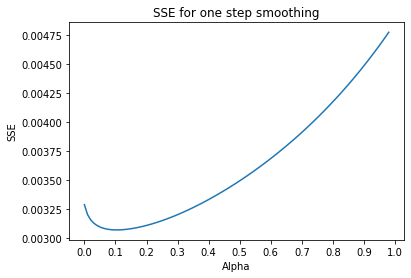

In [35]:
alpha = alpha_grid_search(train)

forecast = ses_forecast(return_square, alpha, length=len(test))

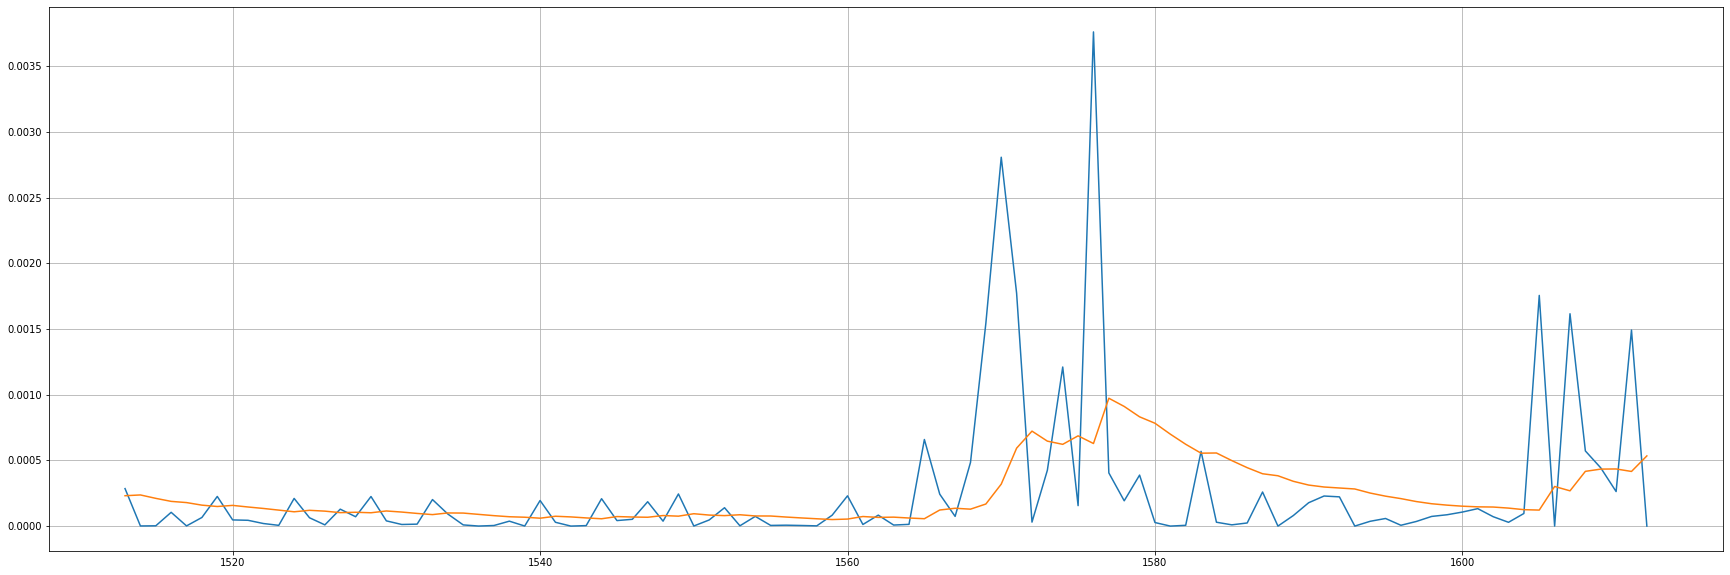

In [36]:
plot_close([test,forecast])

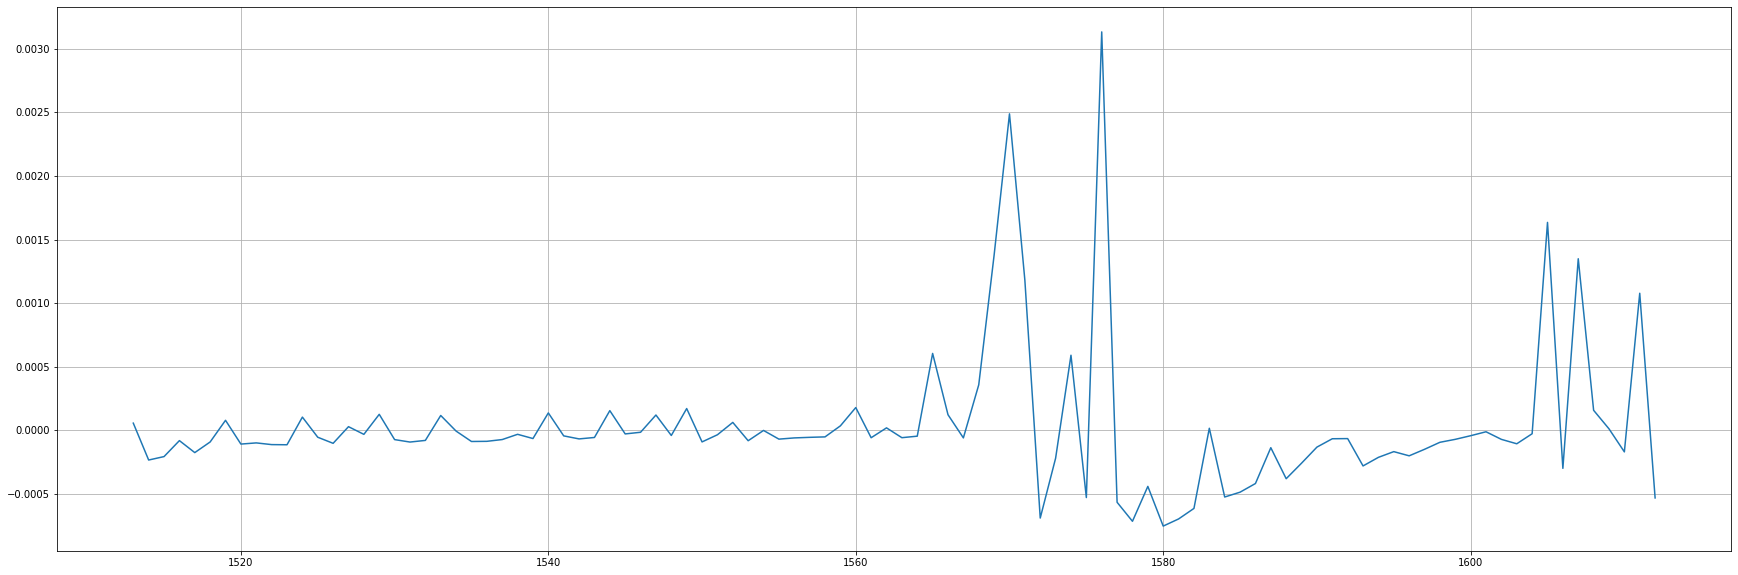

In [37]:
plot_close([test - forecast])

In [ ]:
# mean_absolute_percentage_error(test, forecast)

# h

In [ ]:
def holt(y, alpha, beta, length):
    """
    
    """
    
#    l = [ y[:12].mean() ]
    l = [y[0]]
#    b = [ (sum(y[12:24])-sum(y[:12]))/144 ]
    b = [y[1] - y[0]]

    holtsmoothed = []
    
    Y = y.tolist()
    
    for i in range(len(Y) + length): 
        if i == len(Y) - 1:
            Y.append(l[-1] + b[-1])
            
        l.append(alpha * Y[i] + (1 - alpha) * (l[i] + b[i]))
        b.append(beta * (l[i+1] - l[i]) + (1 - beta) * b[i])
        holtsmoothed.append(l[i] + b[i])
    
    return holtsmoothed

def sse_plot_3d(sse_one, alpha, beta):
    """
    """
    
    fig = plt.figure(figsize= (20,20))
    ax = Axes3D(fig)
    X,Y = np.meshgrid(np.arange(0.01,1,0.01),np.arange(0.01,1,0.01))
    Z = np.array(sse_one).reshape((99,99))
    ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap=plt.get_cmap('rainbow'))
    
    x1 = beta
    y1 = alpha
    z1 = min(sse_one)
    ax.scatter(x1,y1,z1,c='r',marker="v")
    ax.set_xlabel('Beta')
    ax.set_ylabel("Alpha")
    ax.set_zlabel('SSE')


def paras_grid_search(train):
    """
    """
    
    sse_one = []
    for alpha in np.arange(0.01,1,0.01):        
        for beta in np.arange(0.01,1,0.01):
            smoothed = holt(train,alpha,beta,length=0)
            temp_sse = sse(smoothed[1:], train.values[1:])
            sse_one.append(temp_sse)
        
    
    
    alpha = (np.argmin(sse_one) / 99 + 1) * 0.01
    beta = (np.argmin(sse_one) % 99 + 1) * 0.01
    
    sse_plot_3d(sse_one, alpha, beta)
    
    print("Optimal Alpha for 1-step forecast is {0}".format(alpha))
    print("Optimal Beta for 1-step forecast is {0}".format(beta))
    
    return alpha, beta
    


## e

In [ ]:
train = data[:-100]
test = data[-100:]
alpha, beta = paras_grid_search(train)
forecast = pd.Series(holt(train, alpha, beta, len(test)), index = data.index)

In [ ]:
plot_close([data, forecast])

In [ ]:
plot_close([data - forecast])

In [ ]:
plot_close([data[-len(test):], forecast[-len(test):]])

In [ ]:
plot_close([data[-len(test):] - forecast[-len(test):]])

In [ ]:
mean_absolute_percentage_error(test, forecast[-len(test):])

## f

In [ ]:
return_square.index = range(len(return_square))

In [ ]:
train = return_square[:-100]
test = return_square[-100:]

alpha, beta = paras_grid_search(train)
forecast = pd.Series(holt(train, alpha, beta, len(test)), index=return_square.index)

In [ ]:
plot_close([return_square, forecast])

In [ ]:
plot_close([return_square - forecast])

In [ ]:
plot_close([return_square[-len(test):], forecast[-len(test):]])

In [ ]:
plot_close([return_square[-len(test):] - forecast[-len(test):]])